# Matérn kernel on Hyperbolic 

This notebooks illustrates Matérn kernel on a Hyperbolic space.

We use numpy for the computations and matplotlib for vizualization.

In [1]:
import geomstats.visualization as visualization
import matplotlib.pyplot as plt
import numpy as np

INFO: Using numpy backend


We employ that Matérn kernel can be computed via integration of the heat kernel which is analytic in the Hyperbolic space.

In [2]:
from geometric_kernels.kernels.geometric_kernels import MaternIntegratedKernel
from geometric_kernels.spaces.hyperbolic import Hyperbolic

## Instantiate space and kernel

The integral inside the Matérn kernel must be computed numerically. `_NUM_POINTS` stands for the number of nodes to evaluate the integrand at.

In [3]:
_NUM_POINTS = 50

In [4]:
hyperboloid = Hyperbolic(dim=2)
kernel = MaternIntegratedKernel(hyperboloid, _NUM_POINTS)

params, state = kernel.init_params_and_state()
params["nu"] = 3.0/2.0
params["lengthscale"] = 0.5

## Plot kernel values on a "grid"

We construct a quasi-grid in the Hyperbolic space. Since `Hyperbolic` inherits from `geomstats` [Hyperbolic](https://geomstats.github.io/geometry.html#module-geomstats.geometry.hyperbolic), we exploit this:

In [5]:
s = np.linspace(-5, 5, 25)
xx, yy = np.meshgrid(s, s)
points = np.c_[xx.ravel(), yy.ravel()]
points = hyperboloid.from_coordinates(points, "intrinsic")

In [6]:
base_point = hyperboloid.from_coordinates(np.r_[0, 0], "intrinsic")

Again, we use `geomstats` vizualization module to plot data on a Hyperbolic disk.

In [7]:
kernel_vals = kernel.K(params, state, base_point, points)

<AxesSubplot:xlabel='X', ylabel='Y'>

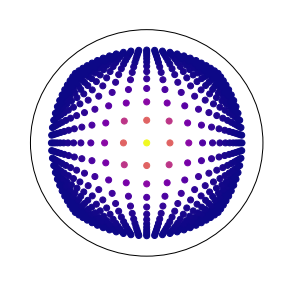

In [8]:
plt.figure(figsize=(5,5))
visualization.plot(points, space="H2_poincare_disk", c=kernel_vals, cmap="plasma")

## Plot kernel values along a geodesic

Let's plot kernel values `K(x, y)` where `y` runs the geodesic between `base` and `end_point`.

In [9]:
base = np.r_[7.14142843, -5.0, -5.0]
end_point = np.r_[14.17744688, 10.0, 10.0]

geodesic = hyperboloid.metric.geodesic(initial_point=base, end_point=end_point)
x1 = geodesic(np.linspace(0.0, 1.0, 100))
x2 = x1[0, None]

distances = hyperboloid.distance(x1, x2)

In [10]:
kernel_vals = kernel.K(params, state, x1, x2)

Text(0, 0.5, 'K')

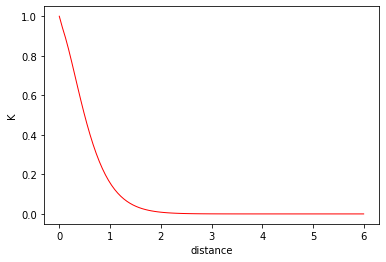

In [11]:
plt.plot(distances, kernel_vals, color="red", linewidth=1)
plt.xlabel('distance')
plt.ylabel('K')